## Homework №2: Text classification (task 2)
*Author: Solonin Maxim*

The task: 
Classify news to one of 5 categories based on text

1. Choose and argue your measure of a test's accuracy.
2. Build data processing and classification pipeline.
3. Tune  your model.

In [25]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
from sklearn.neural_network import MLPClassifier

### Uploading the data from folders

By the way the data link of University of Dublin is broken

In [5]:
data_folder = "C:/Users/Maxim/Desktop/BBC-Dataset-News-Classification-master/dataset/data_files"
folders = ["business","entertainment","politics","sport","tech"]

os.chdir(data_folder)

x = []
y = []

for i in folders:
    files = os.listdir(i)
    for text_file in files:
        file_path = i + "/" +text_file
        with open(file_path) as f:
            data = f.readlines()
        data = ' '.join(data)
        x.append(data)
        y.append(i)
   
data = {'news': x, 'type': y}       
df = pd.DataFrame(data);

### Exploratory data analysis 

In [6]:
df.head() # just understand how the data looks like

,news,type
0,Ad sales boost Time Warner profit\n \n Quarter...,business
1,Dollar gains on Greenspan speech\n \n The doll...,business
2,Yukos unit buyer faces loan claim\n \n The own...,business
3,High fuel prices hit BA's profits\n \n British...,business
4,Pernod takeover talk lifts Domecq\n \n Shares ...,business


The most basic thing about the news texts we can get is their distribution. It is a check for sample imbalance, so that we do not face any problems in future analysis.

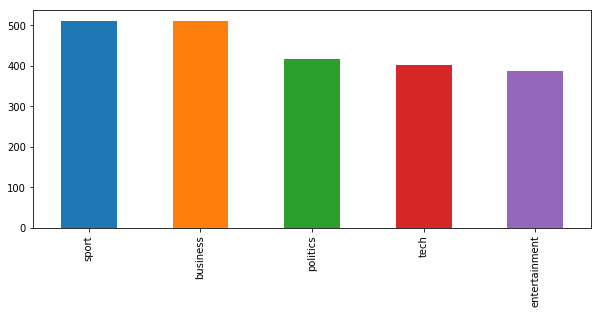

In [7]:
plt.figure(figsize=(10,4))
df.type.value_counts().plot(kind='bar')

It turns out that the number of documents varies from around 400 to 500 for each class, thus we can say that the sample is pretty balanced.

In [8]:
df['class'] = df['type'].factorize()[0] # create a column with classes encoded in digits

I have spotted that new line symbols are presented as "\n" in the docs and decided to filter them, because they do not carry a lot of information.

In [9]:
import re
def scrub_words(text):
    """Basic cleaning of texts."""
    
    # remove html markup
    text=re.sub("\n","",text)
    text=text.strip()
    return text

In [10]:
clean_news = [scrub_words(w) for w in df.news]
clean_news = pd.DataFrame(clean_news)
df['news'] = clean_news

Using tfidf vectorizer is equivalent to count vectorizer with tfidf transformer, but a little bit simpler.

In [11]:
tf_idf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tf_idf.fit_transform(df.news).toarray()
labels = df['class']
features.shape

(2225, 34797)

#### Data split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['news'], df['class'], test_size=0.15, random_state = 72)

I could have done all the models in one pipeline and set grid parameters for multiple classifiers, but I think it would be better to run them manually one by one.

In [26]:
# instead of doing these steps one at a time, we can use a pipeline to complete then all at once
pipeline1 = Pipeline([('vect', tf_idf),
                     ('chi',  SelectKBest(chi2, k=5000)),
                     ('clf', RandomForestClassifier(n_estimators=100))])

pipeline2 = Pipeline([('vect', tf_idf),
                     ('chi',  SelectKBest(chi2, k=5000)),
                     ('clf', LogisticRegression(penalty='l2',multi_class='multinomial',solver='lbfgs'))])

pipeline3 = Pipeline([('vect', tf_idf),
                     ('chi',  SelectKBest(chi2, k=5000)),
                     ('clf', LinearSVC())])
pipeline4 = Pipeline([('vect', tf_idf),
                     ('chi',  SelectKBest(chi2, k=5000)),
                     ('clf', MLPClassifier())])

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
#print(classification_report(ytest, model.predict(X_test)))
#print(confusion_matrix(ytest, model.predict(X_test)))

#### Model results

In [15]:
model_RF = pipeline1.fit(X_train,y_train)
print(classification_report(ytest, model_RF.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96        77
           1       0.98      0.95      0.96        56
           2       1.00      0.94      0.97        62
           3       0.99      1.00      0.99        85
           4       0.96      0.96      0.96        54

   micro avg       0.97      0.97      0.97       334
   macro avg       0.97      0.97      0.97       334
weighted avg       0.97      0.97      0.97       334



In [19]:
model_LR = pipeline2.fit(X_train,y_train)
print(classification_report(ytest, model_LR.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        77
           1       0.98      0.95      0.96        56
           2       1.00      0.98      0.99        62
           3       0.99      1.00      0.99        85
           4       0.98      0.96      0.97        54

   micro avg       0.98      0.98      0.98       334
   macro avg       0.98      0.98      0.98       334
weighted avg       0.98      0.98      0.98       334



In [20]:
model_SVC = pipeline3.fit(X_train,y_train)
print(classification_report(ytest, model_SVC.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        77
           1       0.98      0.98      0.98        56
           2       1.00      1.00      1.00        62
           3       1.00      1.00      1.00        85
           4       0.98      0.98      0.98        54

   micro avg       0.99      0.99      0.99       334
   macro avg       0.99      0.99      0.99       334
weighted avg       0.99      0.99      0.99       334



In [27]:
model_MLP = pipeline4.fit(X_train,y_train)
print(classification_report(ytest, model_MLP.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        77
           1       0.98      0.98      0.98        56
           2       1.00      0.98      0.99        62
           3       1.00      1.00      1.00        85
           4       0.98      0.98      0.98        54

   micro avg       0.99      0.99      0.99       334
   macro avg       0.99      0.99      0.99       334
weighted avg       0.99      0.99      0.99       334



Setting up the parameters for all the models.

In [35]:
parameters1 = {
    'vect__min_df': (2, 3, 5),
    'vect__ngram_range': ((1, 2), (1, 3)),  # trigrams or bigrams
    'chi__k': (2500,5000,"all"),
    'clf__n_estimators': (100,150)
}
parameters2 = {
    'vect__min_df': (2, 3, 5),
    'vect__ngram_range': ((1, 2), (1, 3)),  # trigrams or bigrams
    'chi__k': (2500,5000,'all'),
    'clf__C': (0.1, 1,100),
    'clf__solver': (['saga','lbfgs'])
}
parameters3 = {
    'vect__min_df': (2, 3, 5),
    'vect__ngram_range': ((1, 2), (1, 3)),  # trigrams or bigrams
    'chi__k': (2500,5000,'all'),
    'clf__multi_class':['ovr','crammer_singer'],
    'clf__C': [0.01, 1, 100]
}
parameters4 = {
    'vect__min_df': (2, 3, 5),
    'vect__ngram_range': ((1, 2), (1, 3)),  # trigrams or bigrams
    'chi__k': (2500,5000,'all'),
    'clf__solver': (['sgd','lbfgs','adam'])
}

#### Model tuning

In [33]:

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline1, parameters1, cv=3,
                               n_jobs=-1, verbose=1,scoring='f1_macro')

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline1.steps])
    print("parameters:")
    pprint(parameters1)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score for Random Forest: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters1.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'chi', 'clf']
parameters:
{'chi__k': (2500, 5000, 'all'),
 'clf__n_estimators': (100, 150),
 'vect__min_df': (2, 3, 5),
 'vect__ngram_range': ((1, 2), (1, 3))}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  3.3min finished


done in 205.180s

Best score for Random Forest: 0.961
Best parameters set:
	chi__k: 5000
	clf__n_estimators: 150
	vect__min_df: 2
	vect__ngram_range: (1, 3)


In [36]:

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline2, parameters2, cv=5,
                               n_jobs=-1, verbose=1,scoring='f1_macro')

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline2.steps])
    print("parameters:")
    pprint(parameters2)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score for Logistic Regression: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters2.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'chi', 'clf']
parameters:
{'chi__k': (2500, 5000, 'all'),
 'clf__C': (0.1, 1, 100),
 'clf__solver': ['saga', 'lbfgs'],
 'vect__min_df': (2, 3, 5),
 'vect__ngram_range': ((1, 2), (1, 3))}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 38.8min finished


done in 2335.243s

Best score for Logistic Regression: 0.985
Best parameters set:
	chi__k: 5000
	clf__C: 100
	clf__solver: 'lbfgs'
	vect__min_df: 2
	vect__ngram_range: (1, 2)


C:\Games\Python\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [37]:

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline3, parameters3, cv=5,
                               n_jobs=-1, verbose=1,scoring='f1_macro')

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline3.steps])
    print("parameters:")
    pprint(parameters3)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score for Linear SVC: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters3.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'chi', 'clf']
parameters:
{'chi__k': (2500, 5000, 'all'),
 'clf__C': [0.01, 1, 100],
 'clf__multi_class': ['ovr', 'crammer_singer'],
 'vect__min_df': (2, 3, 5),
 'vect__ngram_range': ((1, 2), (1, 3))}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 21.4min finished


done in 1285.196s

Best score for Linear SVC: 0.985
Best parameters set:
	chi__k: 5000
	clf__C: 1
	clf__multi_class: 'ovr'
	vect__min_df: 5
	vect__ngram_range: (1, 2)


In [38]:

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline4, parameters4, cv=5,
                               n_jobs=-1, verbose=1,scoring='f1_macro')

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline4.steps])
    print("parameters:")
    pprint(parameters4)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score for Multilayer Perceptron: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters4.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'chi', 'clf']
parameters:
{'chi__k': (2500, 5000, 'all'),
 'clf__solver': ['sgd', 'lbfgs', 'adam'],
 'vect__min_df': (2, 3, 5),
 'vect__ngram_range': ((1, 2), (1, 3))}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 54.6min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 137.1min finished


done in 8254.961s

Best score for Multilayer Perceptron: 0.983
Best parameters set:
	chi__k: 5000
	clf__solver: 'adam'
	vect__min_df: 3
	vect__ngram_range: (1, 2)


#### Best performing once again

In [42]:
pip_fin = Pipeline([('vect', TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')),
                     ('chi',  SelectKBest(chi2, k=5000)),
                     ('clf', LinearSVC(C = 1, multi_class = 'ovr'))])
mod_fin = pip_fin.fit(X_train,y_train)
print(classification_report(ytest, mod_fin.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        77
           1       0.98      0.98      0.98        56
           2       1.00      0.98      0.99        62
           3       1.00      1.00      1.00        85
           4       1.00      0.98      0.99        54

   micro avg       0.99      0.99      0.99       334
   macro avg       0.99      0.99      0.99       334
weighted avg       0.99      0.99      0.99       334



In [43]:
pip_fin2 = Pipeline([('vect', TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')),
                     ('chi',  SelectKBest(chi2, k=5000)),
                     ('clf', LogisticRegression(C = 100, solver = 'lbfgs'))])
mod_fin2 = pip_fin2.fit(X_train,y_train)
print(classification_report(ytest, mod_fin2.predict(X_test)))

C:\Games\Python\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99        77
           1       0.98      0.98      0.98        56
           2       1.00      1.00      1.00        62
           3       1.00      1.00      1.00        85
           4       0.98      0.98      0.98        54

   micro avg       0.99      0.99      0.99       334
   macro avg       0.99      0.99      0.99       334
weighted avg       0.99      0.99      0.99       334



####  Conclusions

Regarding the results before and after tuning, it can be stated that all the models perform very well with f1-scores more than 0.96. While RF model tends to use trigrams to show its best result, other models are using bigrams and have higher f1, precision and recall macro metrics. The best identified models are Logistic Regression and Linear Support Vector Classification with f1-macro 0.985 and used bigrams and 5000 features.

According to final results, Logistic regression perfoms the best and predicts news types politics and sport 100% correctly.